In [1]:
import pandas as pd

header_info = ["age",
              "class_of_worker",
              "industry code",
              "occupation code",
              "level of education",
              "wage per hour",
              "entrolled in education as of last week",
              "marital status",
              "major industry code",
              "major occupation code",
              "race",
              "hispanic origin",
              "sex",
              "member of a labor union",
              "reason for unemployment",
              "full or part time employment status",
              "captial gains",
              "capital losses",
              "dividends from stocks",
              "tax filler status",
              "region of previous residence",
              "state of previous residence",
              "detailed household and family status",
              "detailed household summary",
              "migration code",
              "migration code - change in region",
              "migration code - move within region",
              "live in this house one year ago",
              "migration - previous resident in sunbelt",
              "number of persons that worked for employer",
              "family members under 18",
              "country of birth father",
              "country of birth mother",
              "country of birth",
              "citizenship",
              "own business or self-employed",
              "fill included questionaire for veterans administration",
              "veterans benefits",
              "weeks worked in the year",
              "year of survey",
              "income less than or greater than 50,000",
              "number of years of education"]

print(len(header_info))

my_census = pd.read_csv("./census-income.data", names=header_info)



42


In [2]:
my_census.head()


,age,class_of_worker,industry code,occupation code,level of education,wage per hour,entrolled in education as of last week,marital status,major industry code,major occupation code,...,country of birth mother,country of birth,citizenship,own business or self-employed,fill included questionaire for veterans administration,veterans benefits,weeks worked in the year,year of survey,"income less than or greater than 50,000",number of years of education
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


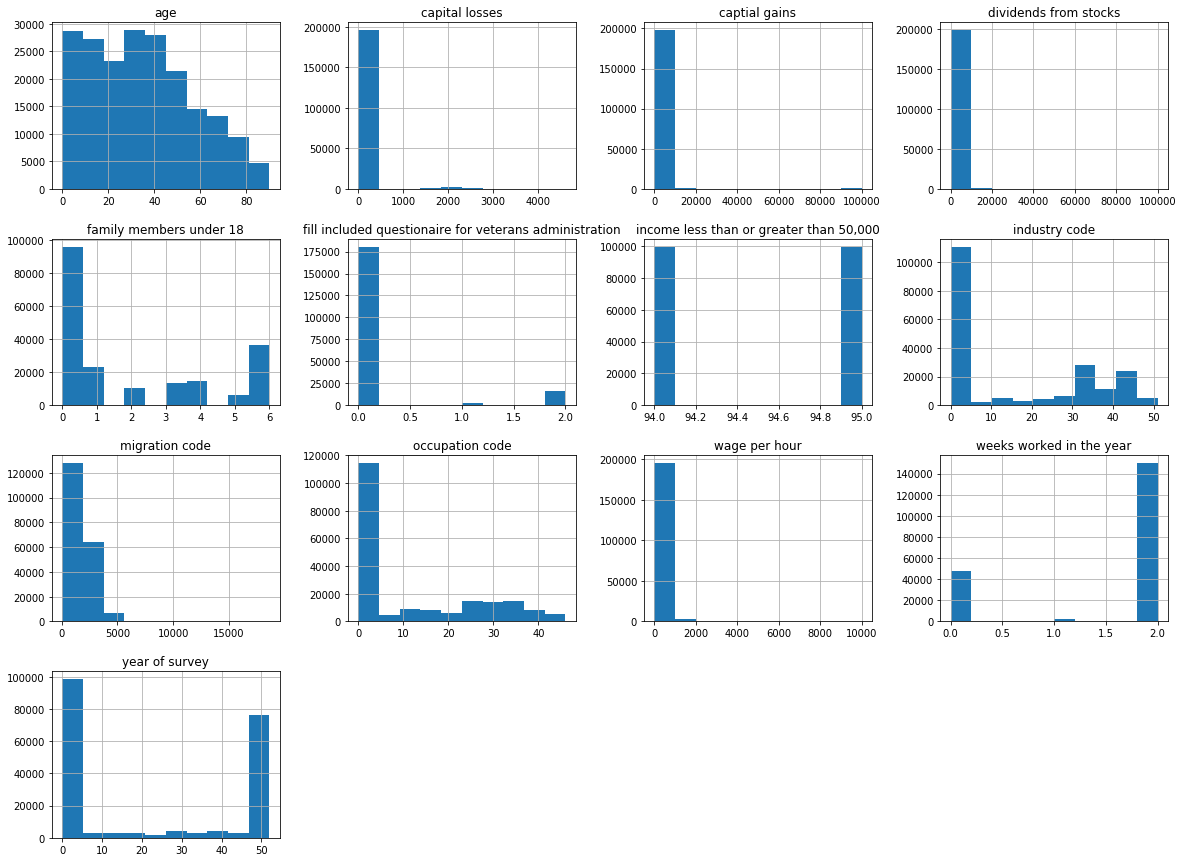

In [3]:
# we have our data... now let's look at it

my_census.describe()

%matplotlib inline
import matplotlib.pyplot as plt
my_census.hist(bins=10, figsize=(20,15))
plt.show()


In [4]:
# We're going to set aside data for our test set (see how well our algorithm performs!)

#helper functions to split train/test data
import hashlib
import numpy as np

def test_set_checker(id, test_ratio, hash):
    return hash(np.int64(id)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_checker(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


my_census_id = my_census.reset_index()

train_set, test_set = split_train_test_by_id(my_census_id, .2, "index")



In [5]:
#actually... just use sklearn's data splitting

import sklearn

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(my_census,test_size=.2,random_state=84)

In [6]:
print("The train set is {} many examples. Whereas the test set contains {} examples.".format(len(train_set),len(test_set)))

#Note that we could do stratified sampling here if we knew which categories were most important

census = train_set.copy()

#drop anything with the word code
#bad_feature = [x for x in header_info if "code" in x]

#census = census.drop(axis=1, labels=bad_feature)
#census = census.drop(axis=1,labels=['number of persons that worked for employer','family members under 18','year of survey','fill included questionaire for veterans administration'])

#drop data if age < 18
#census = census.drop(census[census['age'] <= 18].index)



#census.head()

The train set is 159618 many examples. Whereas the test set contains 39905 examples.


In [7]:
correlation_matrix = census.corr()

correlation_matrix['wage per hour'].sort_values(ascending=False)

wage per hour                                             1.000000
year of survey                                            0.194715
occupation code                                           0.193521
family members under 18                                   0.191718
industry code                                             0.164154
weeks worked in the year                                  0.112671
fill included questionaire for veterans administration    0.051699
age                                                       0.036978
migration code                                            0.011366
capital losses                                            0.010389
income less than or greater than 50,000                   0.002338
captial gains                                            -0.000558
dividends from stocks                                    -0.004960
Name: wage per hour, dtype: float64

In [8]:
from pandas.plotting import scatter_matrix

#attributes = ['dividends from stocks', 'captial gains', 'age']


In [10]:
#here we will encode all categorical values into numerical values
import pandas

categorical_columns = census.select_dtypes(exclude=[np.number])
numerical_columns = census.select_dtypes(include=[np.number])
#census.hist(bins=20, figsize=(20,15))


#cat_to_num_columns = encoder.fit_transform(categorical_columns)


#for category_column_name in categorical_columns.columns.values:
#    print("encoding and replacing :: " + category_column_name)
#    encoded = encoder.fit_transform(categorical_columns[category_column_name])
    
    #print("here's a sample: ")
    #census[category_column_name] = encoded
    

class_category = pandas.get_dummies(census)

class_category.describe()

,age,industry code,occupation code,wage per hour,captial gains,capital losses,dividends from stocks,migration code,family members under 18,fill included questionaire for veterans administration,...,own business or self-employed_ Foreign born- Not a citizen of U S,own business or self-employed_ Foreign born- U S citizen by naturalization,own business or self-employed_ Native- Born abroad of American Parent(s),own business or self-employed_ Native- Born in Puerto Rico or U S Outlying,own business or self-employed_ Native- Born in the United States,veterans benefits_ No,veterans benefits_ Not in universe,veterans benefits_ Yes,number of years of education_ - 50000.,number of years of education_ 50000+.
count,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,...,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000,159618.000000
mean,34.506058,15.403250,11.288025,55.862096,428.687128,37.605370,198.919765,1741.800983,1.956966,0.175344,...,0.067411,0.029477,0.008746,0.007505,0.886861,0.007944,0.990064,0.001992,0.937958,0.062042
std,22.296504,18.076862,14.432765,277.323471,4659.218495,273.116259,1994.601495,995.419115,2.364515,0.553771,...,0.250733,0.169139,0.093110,0.086308,0.316763,0.088774,0.099184,0.044590,0.241232,0.241232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1063.190000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1618.410000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,50.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2189.872500,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,16349.200000,6.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#class_category.info()

import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
test = pca.fit(class_category.values) #.values makes the dataframe into a np array


TypeError: inverse_transform() missing 1 required positional argument: 'X'